# Day 8 - Monte Carlo Methods

## Monte Carlo Estimation of Action Values

* Without a model of the environment, state-values are not enough to suggest a policy, so we must estimate $q_\pi(s,a)$
* Goal: Estimate $q_*$
* The "visits" concept transfers from states $s$ to state-action pairs $s,a$
* A deterministic policy only ever picks one action $a$ in each state, so estimates of other actions cannot be made
* To do so, we need to $maintain\ exploration$
* One way to do so is $exploring\ starts$, where each episode starts with some state-action pair, and each pair has a nonzero probability of being selected
* More practical is to only consider policies that will select each action in each state with a nonzero probability forever

### $Exercise\ \mathcal{5.3}$

#### What is the backup diagram for Monte Carlo estimation of $q_\pi$?

It starts at a state-action pair, and keeps going until reaching the terminal state of an episode, as seen below.

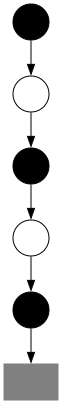

In [9]:
from graphviz import Digraph

dot = Digraph()

dot.node('a1',  '', shape='circle', style='filled', color='black')
dot.node('s1', '', shape='circle')
dot.node('a2',  '', shape='circle', style='filled', color='black')
dot.node('s2', '', shape='circle')
dot.node('a3',  '', shape='circle', style='filled', color='black')
dot.node('t', '', shape='box', style='filled', color='gray')

dot.edge('a1', 's1')
dot.edge('s1', 'a2')
dot.edge('a2', 's2')
dot.edge('s2', 'a3')
dot.edge('a3', 't')

dot

## Monte Carlo Control

* To extend Monte Carlo methods to control, we simply have to perform generalized policy iteration with our Monte Carlo estimates
* With infinitely many generated episodes and exploring starts, Monte Carlo methods compute $q_{\pi_k}$ exactly for any policy $\pi_k$
* Then, we can perform policy improvement, by selecting $\pi_{k+1}(s)=\operatorname{arg}\underset{a}{\operatorname{max}}q_{\pi_k}(s,a)$, from which follows that

$$
\begin{align}
q_{\pi_k}(s,\pi_{k+1}(s))&=q_{\pi_k}(s,\operatorname{arg}\underset{a}{\operatorname{max}}q_{\pi_k}(s,a)) \\
&=\underset{a}{\operatorname{max}}q_{\pi_k}(s,a) \\
&\ge q_{\pi_k}(s,\pi_k(s)) \\
&=v_{\pi_k}(s).
\end{align}
$$
* As our assumptions are unrealistic, we have to remove them for a practical algorithm
* To avoid having to sample infinitely many episodes, we can simply perform updates of both $q$ after each episode, for all states visited, and then update $\pi$
* Convergence is not proven

### $Exercise\ \mathcal{5.4}$

#### The pseudocode for Monte Carlo ES is inefficient because, for each state–action pair, it maintains a list of all returns and repeatedly calculates their mean. It would be more efficient to use techniques similar to those explained in Section 2.4 to maintain just the mean and a count (for each state–action pair) and update them incrementally. Describe how the pseudocode would be altered to achieve this.

Instead of initializing
$$
Returns(s,a)\leftarrow\text{empty list, for all }s\in\mathcal{S},\ a\in\mathcal{A},
$$
they should be initialized as
$$
\begin{align}
&Return(s,a)\leftarrow0\text{, for all }s\in\mathcal{S},\ a\in\mathcal{A} \\
&N(s,a)\leftarrow0\text{, for all }s\in\mathcal{S},\ a\in\mathcal{A}
\end{align}
$$
The altered part of the update rule would then be
$$
\begin{align}
&N(s,a)\leftarrow N(s,a)+1 \\
&Return(s,a)\leftarrow Return(s,a)+\frac{1}{N(s,a)}\left(G-Returns(s,a)\right)\\
&Q(S_t,A_t)\leftarrow Return(s,a).
\end{align}
$$

## Monte Carlo Control without Exploring Starts

* To avoid exploring starts, which is an unrealistic assumption if we do not have direct control over where we start in the environment, we instead ensure visiting all state-action pairs by using $\varepsilon$-greedy policies
* An $\varepsilon$-greedy policy is a special case of $\varepsilon$-soft policies, for which each action $a$ is chosen with a probability $\ge\frac{\varepsilon}{|\mathcal{A}(s)|}$
* By performing GPI, we move this policy closer toward the optimal policy
* The policy improvement theorem shows this, if we let $\pi'$ be the policy that is $\varepsilon$-greed with respect to $v_\pi$

$$
\begin{align}
q_\pi(s,\pi'(s))&=\sum_a\pi'(a|s)q_\pi(s,a) \\
&=\frac{\varepsilon}{|\mathcal{A}(s)|}\sum_aq_\pi(s,a)+(1-\varepsilon)\underset{a}{\operatorname{max}}q_\pi(s,a) \\
&\ge\frac{\varepsilon}{|\mathcal{A}(s)|}\sum_aq_\pi(s,a)+(1-\varepsilon)\sum_a\frac{\pi(a|s)-\frac{\varepsilon}{|\mathcal{A}(s)|}}{1-\varepsilon}q_\pi(s,a) \\
&=\frac{\varepsilon}{|\mathcal{A}(s)|}\sum_aq_\pi(s,a)-\frac{\varepsilon}{|\mathcal{A}(s)|}\sum_aq_\pi(s,a)+\sum_a\pi(a|s)q_\pi(s,a) \\
&=v_\pi(s)
\end{align}
$$
* We define a new environment, in which action $a$ in state $s$ leads to the same state as in the original environment with a probability of $1-\varepsilon$, and with a probability of $\frac{\varepsilon}{|\mathcal{A}(s)|}$, it chooses a random, new action $a$ instead, and transitions to the state corresponding to that. In this new environment, the optimal value function is $\tilde{v}_*(s)$

$$
\begin{align}
\tilde{v}_*(s)&=\underset{a}{\operatorname{max}}\sum_{s',r}\Biggr[(1-\varepsilon)p(s',r|s,a)+\sum_{a'}\frac{\varepsilon}{|\mathcal{A}(s)|}p(s',r|s,a')\Biggr]\Biggr[r+\gamma \tilde{v}_*(s')\Biggr] \\
&=(1-\varepsilon)\underset{a}{\operatorname{max}}\sum_{s',r}p(s',r|s,a)\Biggr[r+\gamma \tilde{v}_*(s')\Biggr] \\
&\quad+\frac{\varepsilon}{|\mathcal{A}(s)|}\sum_{a'}\sum_{s',r}p(s',r|s,a)\Biggr[r+\gamma \tilde{v}_*(s')\Biggr] \\
\end{align}
$$
* If our estimate has converged, then the equality $q_\pi(s,\pi'(s))=v_\pi(s)$ holds, in which case

$$
\begin{align}
v_\pi(s)&=\frac{\varepsilon}{|\mathcal{A}(s)|}\sum_aq_\pi(s,a)+(1-\varepsilon)\underset{a}{\operatorname{max}}q_\pi(s,a) \\
&=(1-\varepsilon)\underset{a}{\operatorname{max}}\sum_{s',r}p(s',r|s,a)\Biggr[r+v_\pi(s')\Biggr] \\
&\quad+\frac{\varepsilon}{|\mathcal{A}(s)|}\sum_a\sum_{s',r}p(s',r|s,a)\Biggr[r+v_\pi(s')\Biggr]
\end{align}
$$

* As this is the same expression as for $\tilde{v}_*(s)$, which we know to be unique, $\tilde{v}_*(s)=v_\pi(s)$
* So, policy iteration works for $\varepsilon$-soft policies in general, and therefore for $\varepsilon$-greedy policies in particular

## Off-policy Prediction via Importance Sampling

* Learning control methods want to know optimal values from behaving non-optimally
* By utilizing $off\ policy$ methods, this can be done
* Keep one $target\ policy$ $\pi$, for which to estimate action values, and the behavior policy $b$, with which to generate sample returns
* Every action taken under $\pi$ has to be taken under $b$ as well, in order to estimate the action values
* So $b$ must be stochastic in states where it is not equal to $\pi$
* Off-policy methods are slower to converge, due to high variance, but more general and powerful
* Sampled trajectories are weighted according to their $importance$-$sampling\ ratio$

$$
\begin{align}
\rho_{t:T-1}&=\prod_{k=t}^{T-1}\frac{\pi(A_k|S_k)}{b(A_k|S_k)} \\
\mathbb E_b[\rho_{t:T-1} G_t|S_t=s]&=v_\pi(s)
\end{align}
$$
* To generalize across episodes, increase $t$ across episode boundaries, and let $\mathcal{T}(s)$ denote the time steps $t$ in which state $s$ was visited, and $T(t)$ the first episode termination after time step $t$, which makes $G_t$ the return starting from time step $t$, ending at $T(t)$
* The value estimate of state $s$ is then

$$
V(s)\doteq\frac{\sum_{t\in\mathcal{T}(s)}\rho_{t:T(t)-1}G_t}{|\mathcal{T}(s)|}
$$
* This is $ordinary$ importance sampling, which is unbiased, but has high variance, while $weighted$ importance sampling is biased, but has low variance, often being preferred in practice

$$
V(s)\doteq\frac{\sum_{t\in\mathcal{T}(s)}\rho_{t:T(t)-1}G_t}{\sum_{t\in\mathcal{T}(s)}\rho_{t:T(t)-1}}
$$
* Deciding between first-visit and every-visit methods, the simpler every-visit method is preferred in practice, and works well

### $Exercise\ \mathcal{5.5}$

#### Consider an MDP with a single nonterminal state and a single action that transitions back to the nonterminal state with probability $p$ and transitions to the terminal state with probability $1-p$. Let the reward be $+1$ on all transitions, and let $\gamma=1$. Suppose you observe one episode that lasts 10 steps, with a return of 10. What are the first-visit and every-visit estimators of the value of the nonterminal state?

The first-visit estimate will simply be the return observed from the episode, $10$. The every-visit method, however, will average the returns experienced from all 10 visits to that state, giving $\frac{\sum_{i=1}^{10}i}{10}=5.5$.

### $Exercise\ \mathcal{5.6}$

#### What is the equation analogous to (5.6) for $action$ values $Q(s,a)$ instead of state values $V(s)$, again given returns generated using $b$?

$$
Q(s,a)\doteq\frac{\sum_{t\in\mathcal{T}(s,a)}\rho_{t:T(t)-1}G_t}{\sum_{t\in\mathcal{T}(s,a)}\rho_{t:T(t)-1}}
$$

### $Exercise\ \mathcal{5.7}$

#### In learning curves such as those shown in Figure 5.3 error generally decreases with training, as indeed happened for the ordinary importance-sampling method. But for the weighted importance-sampling method error first increased and then decreased. Why do you think this happened?

I don't know exactly why that would be the case, but my intuition leads me in the direction of high importance-sampling ratios introducing bias early on, as they dominate the estimate, getting averaged out slowly over time. But that does not explain the initially *low* error.

### $Exercise\ \mathcal{5.8}$

#### The results with Example 5.5 and shown in Figure 5.4 used a first-visit MC method. Suppose that instead an every-visit MC method was used on the same problem. Would the variance of the estimator still be infinite? Why or why not? 

I'm unable to prove this rigorously, but for every $n$-step episode, the estimate is also updated for the $1, 2, \dots, n-1$-step sub-episodes contained within, heavily discounting longer episodes in the overall estimate. This should reduce the variance, and at least $feels$ like we have some $\frac{1}{2^k}$-adjacent series invovled somewhere, which should converge.